In [59]:
#in this cell I set the filename of the data

%matplotlib inline
import sys
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

ifname = 'winequality-red.csv'



In [60]:
#In this cell the data is imported from the file and standardised

with open(ifname, 'r') as ifile:
        datareader = csv.reader(ifile, delimiter=';')
        #Assume the first row is the header
        header = next(datareader)
        data = []
        for row in datareader:
            row_of_floats = list(map(float,row))
            data.append(row_of_floats)
        data_as_array = np.array(data)

good_quality_wine = 6 #this variable states the threshold used ot determine what is a good quality wine. in this case we say
#a good quality wine is one which is >5, a bad quality wine is <=5

uncoded_targets = data_as_array[:,-1] #we assume here that the last column of the dataset is the targets
good_wines = uncoded_targets > good_quality_wine
targets = good_wines.astype(np.int) #created a 1D vector where 0 = bad wine, 1 = good wine
data_matrix = data_as_array[:, 0:-1] #data_matrix is a 2D array which can be used to represent all the 
#datapoints where is row is a datapoint

N = data_matrix.shape[0] 
#N is equal to the number of data points
Dim = data_matrix.shape[1]
#Dim is equal to the number of attribute of the data

#standardising data below
standardised_data = np.zeros([N , Dim])
for i in range(Dim): 
    column_i = data_matrix[:,i]
    column_i_mean = np.mean(column_i)
    colum_i_std = np.std(column_i)
    standardised_data[:,i] = (column_i - column_i_mean) / colum_i_std



In [61]:
#This tells us how mahy good wines we have
print('the number of good quality wines is {}'.format(np.sum(targets)))

the number of good quality wines is 217


In [62]:
#In the following cells  we will run fischers linear discriminant on the data in it standardised form without 
# the use of basis functions. Its performance will be asessed using cross validation and ROC

#This cell will import and define the functions needed to do this

from fomlads.model.classification import fisher_linear_discriminant_projection
from fomlads.model.classification import project_data
from fomlads.plot.exploratory import plot_class_histograms
from fomlads.plot.evaluations import plot_roc

def fischerpredicts(w0, projected_inputs):
    
    #This function takes a value of w0 and applies it to projected inputs.
    #w0 is the "threshold" or "cutoff" used to predict class membership
    #projected_inputs is what you get when multiplying the weights (found by fishers) by the inputs, it is 1D
    #predicts is a vecor where each  number is 1 or 0
    N = projected_inputs.shape[0]
    predicts = np.zeros([N])
    for i in range(N):
        if projected_inputs[i] > w0:
            predicts[i] = 1
            
    return predicts


In [63]:
#Below we return the weights for fischers linear discriminant where the input data is s a standarsided matrix with
#no Basis functions

weights = fisher_linear_discriminant_projection(standardised_data, targets)

#Below we use these weights to project the data into one dimension and the result is a one dimensional vector called 
#projected_inputs, this can then be used to visualise the data as a histogram to see how seperable it is

projected_data = project_data(standardised_data, weights)

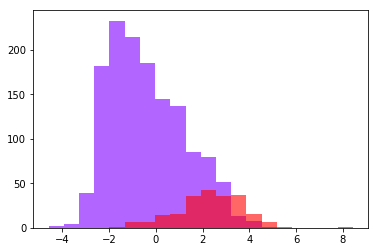

In [64]:
#Below is a histogram to show how linearly seperable the data is

plot_class_histograms(projected_data, targets)

plt.show()

In [65]:
#In this cell we obtain all the data we need to construct the ROC curve

new_ordering = np.argsort(projected_data)
sorted_projections = projected_data[new_ordering]
sorted_targets = targets[new_ordering]

num_neg = np.sum(1-targets)
num_pos = np.sum(targets)

#Below is a 2D array with 5 colums. The array is alled roc_data
#Column 1 is numbers in ascending order (ie 1, 2, 3, 4, 5 etc)
#Column 2 is a value of w0
#Column 3 is the false positive rate (FPR) for a given value of w0
#Column 4 is the true positive rate (TPR) for a given value of 
#Column 5 gives the value of TPR - FPR


roc_data = np.empty([N, 5])

for i, w0 in enumerate(sorted_projections):
        roc_data[i,0] = i
        roc_data[i,1] = sorted_projections[i]
        roc_data[i,2] = np.sum(1-sorted_targets[i:])/num_neg
        FPR = roc_data[i,2]
        roc_data[i,3] = np.sum(sorted_targets[i:])/num_pos
        TPR = roc_data[i,3]
        roc_data[i,4] = TPR - FPR


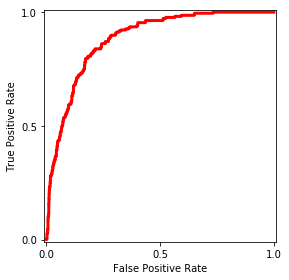

In [66]:
#In this cell we actully plot the roc curve using the data 
#from the roc_data array

plot_roc(roc_data[:,2], roc_data[:,3])

plt.show()

In [67]:
#In this cell we find the value of w0 which gives the best performance 
#(ie which gives the higest number for TPR - FPR

highest_value_indicies = np.argmax(roc_data, axis=0)
print('the best w0 is {0}'.format(roc_data[highest_value_indicies[4], 1]))

w0 = roc_data[highest_value_indicies[4], 1]

predictions = fischerpredicts(w0, projected_data)

the best w0 is 1.0374279947238194


In [68]:
#Run tbhis cell if you want to see how the predictions using finschers and w0 compares to the actual targets
for i in range(N):
    pred = predictions[i]
    actual = targets[i]
    # print('at {0}, prediction = {1}, actual = {2}'.format(i, pred, actual))
    # Uncomment the above line to see the preductions compare dot the actual target

In [69]:
#Below we will use cross validation in order to find the average minimum misclassification of the model we have found 
#By model I am reffering to the the use of fischers and the value of w0 we have selected above

#In this cell we define/import the functions needed for the cross validation

from t3.regression_train_test import create_cv_folds
from t3.regression_train_test import train_and_test_partition
from fomlads.evaluate.eval_classification import misclassification_error



def cross_val_fishers(w0, inputs, targets, folds):
    #this function performs a cross validation on the fischers model we hav created above
    #w0 = the threshold value we found to be the besdt cutoff to identify class memebership from the projected data vector
    #inputs = our data points in the form of a matrix
    #targets = the actual class membership of each data oint in 1s and 0s
    #folds = this is an array containing tuples, the tuples contain a pair of boolean arrays. this is creasted from the
    #create cv_folds() function in tutorial 3 (regression_train_test.py)
    
    N = inputs.shape[0] #Number of data points
    num_folds = len(folds) #finds the number of folds
    train_errors = np.empty(num_folds)
    test_errors = np.empty(num_folds)
    
    for f,fold in enumerate(folds):
        train_part, test_part = fold
        train_inputs, train_targets, test_inputs, test_targets = train_and_test_partition(inputs, targets, train_part, test_part)
        weights = fisher_linear_discriminant_projection(train_inputs, train_targets)
        
        train_projected_data = project_data(train_inputs, weights)
        train_predicts = fischerpredicts(w0, train_projected_data)
        
        test_projected_data = project_data(test_inputs, weights)
        test_predicts = fischerpredicts(w0, test_projected_data)
        
        train_error = misclassification_error(train_targets, train_predicts)
        test_error = misclassification_error(test_targets, test_predicts)

        train_errors[f] = train_error
        test_errors[f] = test_error
        
    #the first array retruned is the the training errors. It a X number of values where X is the number of folds
    #used to perform the cross validation, each number in the array represents the misclassification error of the training data
    #within that particular "experiment"
    
    #the second asrray is the test errors, it is the same as the first array but the error was calculated on the held out 
    #test data
    

    return train_errors, test_errors


In [70]:
#in this cell the user can specify how many folds they want
num_folds = 3 #change this value to change the number of folds
folds = create_cv_folds(N, num_folds) #folds created using the function from tutorial 3, folds is used 
#as an input arguement for the cross_val_fishers() function defined above


In [72]:
#this cell runs the function which carries out the cross validation, all the input arguements have been defined above
#it returns two arrays
train_error, test_error = cross_val_fishers(w0, standardised_data, targets, folds)
print("the misclassification error is {}".format(np.mean(test_error)))

the misclassification error is 0.21450906816760476


In [73]:
#The above model is not the best as can be seen from the ROC curve and the test_error elicited from the cross validation. 
#we shall therefore do this again by trying to find the best design matrix for our data points. 
#We will use Radil Basis Functions as our basis functions
#This will require the process of model selection
#In this cell we import the functions we need

from t3.regression_models import construct_rbf_feature_mapping

In [30]:
#RBFs are defined by two parameters, 1) the number of centers
#2) the scale of the basis functions

scales = np.linspace(0.1,9, 50)
array_of_numbers_of_centres = np.around(np.linspace(1,90, 50)).astype(int)
heat_map = np.zeros([scales.size, array_of_numbers_of_centres.size]) #heat map is a matrix which will show the different
#error for each configuration of our parameters of scale and number of centers. each element of the heat map will be a 
#different error value representing the test error obtained from cross validation for a different pair of numberofcentres/scale
#each row in the heat map is representing the scale
#each column in the heat mep is representing the number of centers
parameter_list = [] #this is a list of the parameters which has indicies which correspond to the heatmap, an example of this:
#if np.argmin(heat_map) yields the number 17 then parameter_list[17] will contain a list [scale, centres] which gives the lowest
#error in the heat_map


for i, scale in enumerate(scales):
    for j, number_of_centres in enumerate(array_of_numbers_of_centres):
        
    
        indexes = np.random.choice(N,number_of_centres) #here is one of the biggest flaws in our model selection
        #we are selecting our centres RANDOMLY, according to the literature np.random.choice selects values randomly according to
        #a unifrom distribution
        centres = standardised_data[indexes,:]             
        feature_mapping = construct_rbf_feature_mapping(centres,scale)
        designmtx = feature_mapping(standardised_data)
        parameter_list.append([scale, centres])
    
        try:
            weights_ms = fisher_linear_discriminant_projection(designmtx, targets) #the "_ms" after "weights" stands for 
#model selection to help distinguish it from the "weights" variable above.
            projected_data_ms = project_data(designmtx, weights_ms)
            new_ordering_ms = np.argsort(projected_data_ms)
            sorted_projections_ms = projected_data_ms[new_ordering_ms]
            sorted_targets = targets[new_ordering_ms]
            num_neg = np.sum(1-targets)
            num_pos = np.sum(targets)
    
            find_optimal_w0 = np.empty([N, 2])
            for idx, w0 in enumerate(sorted_projections_ms):
                find_optimal_w0[idx,0] = sorted_projections[idx]
                FPR = np.sum(1-sorted_targets[idx:])/num_neg
                TPR = np.sum(sorted_targets[idx:])/num_pos
                find_optimal_w0[idx,1] = TPR - FPR
    
            indexes_to_find_best_w0 = np.argmax(find_optimal_w0, axis=0)
            w0_ms = find_optimal_w0[indexes_to_find_best_w0[1], 0]
            train_errors, test_errors = cross_val_fishers(w0_ms, designmtx, targets, folds)
        
        except np.linalg.LinAlgError:
            print('A singular matrix was encountered when the scale was {} and the number of centres was {}'.format(scale, number_of_centres))
            test_errors = 1.01
            
        heat_map[i, j] = np.mean(test_errors)
        print("finished element {}/{} on heatmap".format(j + i*(len(array_of_numbers_of_centres)),heat_map.size - 1))
        

    
    


finished element 0/2499 on heatmap
finished element 1/2499 on heatmap
finished element 2/2499 on heatmap
finished element 3/2499 on heatmap
finished element 4/2499 on heatmap
finished element 5/2499 on heatmap
finished element 6/2499 on heatmap
finished element 7/2499 on heatmap
finished element 8/2499 on heatmap
finished element 9/2499 on heatmap
finished element 10/2499 on heatmap
finished element 11/2499 on heatmap
finished element 12/2499 on heatmap
A singular matrix was encountered when the scale was 0.1 and the number of centres was 25
finished element 13/2499 on heatmap
finished element 14/2499 on heatmap
finished element 15/2499 on heatmap
A singular matrix was encountered when the scale was 0.1 and the number of centres was 30
finished element 16/2499 on heatmap
A singular matrix was encountered when the scale was 0.1 and the number of centres was 32
finished element 17/2499 on heatmap
finished element 18/2499 on heatmap


N:\DesktopSettings\Desktop\INST Coursework\project_submission-20190321T133031Z-001\project_submission\fomlads\model\classification.py:59: RuntimeWarning: invalid value encountered in true_divide
  weights = weights/np.sum(weights)


finished element 19/2499 on heatmap
finished element 20/2499 on heatmap
finished element 21/2499 on heatmap
finished element 22/2499 on heatmap
finished element 23/2499 on heatmap
finished element 24/2499 on heatmap
finished element 25/2499 on heatmap
finished element 26/2499 on heatmap
A singular matrix was encountered when the scale was 0.1 and the number of centres was 50
finished element 27/2499 on heatmap
finished element 28/2499 on heatmap
finished element 29/2499 on heatmap
A singular matrix was encountered when the scale was 0.1 and the number of centres was 55
finished element 30/2499 on heatmap
finished element 31/2499 on heatmap
finished element 32/2499 on heatmap
finished element 33/2499 on heatmap
finished element 34/2499 on heatmap
finished element 35/2499 on heatmap
finished element 36/2499 on heatmap
finished element 37/2499 on heatmap
finished element 38/2499 on heatmap
finished element 39/2499 on heatmap
finished element 40/2499 on heatmap
finished element 41/2499 on 

A singular matrix was encountered when the scale was 0.6448979591836735 and the number of centres was 46
finished element 175/2499 on heatmap
finished element 176/2499 on heatmap
finished element 177/2499 on heatmap
finished element 178/2499 on heatmap
finished element 179/2499 on heatmap
A singular matrix was encountered when the scale was 0.6448979591836735 and the number of centres was 55
finished element 180/2499 on heatmap
finished element 181/2499 on heatmap
finished element 182/2499 on heatmap
finished element 183/2499 on heatmap
finished element 184/2499 on heatmap
finished element 185/2499 on heatmap
finished element 186/2499 on heatmap
finished element 187/2499 on heatmap
finished element 188/2499 on heatmap
finished element 189/2499 on heatmap
finished element 190/2499 on heatmap
finished element 191/2499 on heatmap
finished element 192/2499 on heatmap
finished element 193/2499 on heatmap
finished element 194/2499 on heatmap
finished element 195/2499 on heatmap
finished elem

N:\DesktopSettings\Desktop\INST Coursework\project_submission-20190321T133031Z-001\project_submission\fomlads\model\classification.py:59: RuntimeWarning: divide by zero encountered in true_divide
  weights = weights/np.sum(weights)


finished element 240/2499 on heatmap
A singular matrix was encountered when the scale was 0.826530612244898 and the number of centres was 75
finished element 241/2499 on heatmap
A singular matrix was encountered when the scale was 0.826530612244898 and the number of centres was 77
finished element 242/2499 on heatmap
finished element 243/2499 on heatmap
A singular matrix was encountered when the scale was 0.826530612244898 and the number of centres was 81
finished element 244/2499 on heatmap
finished element 245/2499 on heatmap
A singular matrix was encountered when the scale was 0.826530612244898 and the number of centres was 85
finished element 246/2499 on heatmap
finished element 247/2499 on heatmap
finished element 248/2499 on heatmap
A singular matrix was encountered when the scale was 0.826530612244898 and the number of centres was 90
finished element 249/2499 on heatmap
finished element 250/2499 on heatmap
finished element 251/2499 on heatmap
finished element 252/2499 on heatmap

finished element 402/2499 on heatmap
finished element 403/2499 on heatmap
finished element 404/2499 on heatmap
finished element 405/2499 on heatmap
A singular matrix was encountered when the scale was 1.553061224489796 and the number of centres was 12
finished element 406/2499 on heatmap
finished element 407/2499 on heatmap
finished element 408/2499 on heatmap
finished element 409/2499 on heatmap
finished element 410/2499 on heatmap
finished element 411/2499 on heatmap
A singular matrix was encountered when the scale was 1.553061224489796 and the number of centres was 23
finished element 412/2499 on heatmap
finished element 413/2499 on heatmap
finished element 414/2499 on heatmap
finished element 415/2499 on heatmap
finished element 416/2499 on heatmap
finished element 417/2499 on heatmap
finished element 418/2499 on heatmap
finished element 419/2499 on heatmap
finished element 420/2499 on heatmap
finished element 421/2499 on heatmap
finished element 422/2499 on heatmap
finished elemen

finished element 576/2499 on heatmap
finished element 577/2499 on heatmap
finished element 578/2499 on heatmap
A singular matrix was encountered when the scale was 2.0979591836734697 and the number of centres was 54
finished element 579/2499 on heatmap
finished element 580/2499 on heatmap
finished element 581/2499 on heatmap
finished element 582/2499 on heatmap
finished element 583/2499 on heatmap
finished element 584/2499 on heatmap
finished element 585/2499 on heatmap
finished element 586/2499 on heatmap
finished element 587/2499 on heatmap
finished element 588/2499 on heatmap
finished element 589/2499 on heatmap
finished element 590/2499 on heatmap
A singular matrix was encountered when the scale was 2.0979591836734697 and the number of centres was 75
finished element 591/2499 on heatmap
finished element 592/2499 on heatmap
finished element 593/2499 on heatmap
finished element 594/2499 on heatmap
A singular matrix was encountered when the scale was 2.0979591836734697 and the number 

finished element 746/2499 on heatmap
finished element 747/2499 on heatmap
finished element 748/2499 on heatmap
A singular matrix was encountered when the scale was 2.6428571428571432 and the number of centres was 90
finished element 749/2499 on heatmap
finished element 750/2499 on heatmap
finished element 751/2499 on heatmap
finished element 752/2499 on heatmap
finished element 753/2499 on heatmap
finished element 754/2499 on heatmap
finished element 755/2499 on heatmap
finished element 756/2499 on heatmap
finished element 757/2499 on heatmap
finished element 758/2499 on heatmap
finished element 759/2499 on heatmap
finished element 760/2499 on heatmap
finished element 761/2499 on heatmap
finished element 762/2499 on heatmap
finished element 763/2499 on heatmap
finished element 764/2499 on heatmap
finished element 765/2499 on heatmap
finished element 766/2499 on heatmap
finished element 767/2499 on heatmap
finished element 768/2499 on heatmap
finished element 769/2499 on heatmap
finishe

finished element 909/2499 on heatmap
finished element 910/2499 on heatmap
finished element 911/2499 on heatmap
finished element 912/2499 on heatmap
finished element 913/2499 on heatmap
finished element 914/2499 on heatmap
finished element 915/2499 on heatmap
finished element 916/2499 on heatmap
finished element 917/2499 on heatmap
finished element 918/2499 on heatmap
finished element 919/2499 on heatmap
finished element 920/2499 on heatmap
finished element 921/2499 on heatmap
finished element 922/2499 on heatmap
finished element 923/2499 on heatmap
finished element 924/2499 on heatmap
finished element 925/2499 on heatmap
finished element 926/2499 on heatmap
finished element 927/2499 on heatmap
finished element 928/2499 on heatmap
A singular matrix was encountered when the scale was 3.369387755102041 and the number of centres was 54
finished element 929/2499 on heatmap
finished element 930/2499 on heatmap
A singular matrix was encountered when the scale was 3.369387755102041 and the num

finished element 1074/2499 on heatmap
finished element 1075/2499 on heatmap
finished element 1076/2499 on heatmap
A singular matrix was encountered when the scale was 3.9142857142857146 and the number of centres was 50
finished element 1077/2499 on heatmap
finished element 1078/2499 on heatmap
finished element 1079/2499 on heatmap
A singular matrix was encountered when the scale was 3.9142857142857146 and the number of centres was 55
finished element 1080/2499 on heatmap
A singular matrix was encountered when the scale was 3.9142857142857146 and the number of centres was 57
finished element 1081/2499 on heatmap
finished element 1082/2499 on heatmap
finished element 1083/2499 on heatmap
A singular matrix was encountered when the scale was 3.9142857142857146 and the number of centres was 63
finished element 1084/2499 on heatmap
finished element 1085/2499 on heatmap
finished element 1086/2499 on heatmap
finished element 1087/2499 on heatmap
finished element 1088/2499 on heatmap
finished e

finished element 1221/2499 on heatmap
finished element 1222/2499 on heatmap
finished element 1223/2499 on heatmap
finished element 1224/2499 on heatmap
finished element 1225/2499 on heatmap
A singular matrix was encountered when the scale was 4.459183673469388 and the number of centres was 48
finished element 1226/2499 on heatmap
finished element 1227/2499 on heatmap
finished element 1228/2499 on heatmap
finished element 1229/2499 on heatmap
finished element 1230/2499 on heatmap
finished element 1231/2499 on heatmap
finished element 1232/2499 on heatmap
finished element 1233/2499 on heatmap
finished element 1234/2499 on heatmap
finished element 1235/2499 on heatmap
finished element 1236/2499 on heatmap
finished element 1237/2499 on heatmap
A singular matrix was encountered when the scale was 4.459183673469388 and the number of centres was 70
finished element 1238/2499 on heatmap
finished element 1239/2499 on heatmap
finished element 1240/2499 on heatmap
finished element 1241/2499 on he

finished element 1366/2499 on heatmap
finished element 1367/2499 on heatmap
A singular matrix was encountered when the scale was 5.004081632653061 and the number of centres was 34
finished element 1368/2499 on heatmap
finished element 1369/2499 on heatmap
finished element 1370/2499 on heatmap
finished element 1371/2499 on heatmap
finished element 1372/2499 on heatmap
finished element 1373/2499 on heatmap
finished element 1374/2499 on heatmap
finished element 1375/2499 on heatmap
finished element 1376/2499 on heatmap
finished element 1377/2499 on heatmap
finished element 1378/2499 on heatmap
finished element 1379/2499 on heatmap
finished element 1380/2499 on heatmap
finished element 1381/2499 on heatmap
finished element 1382/2499 on heatmap
finished element 1383/2499 on heatmap
finished element 1384/2499 on heatmap
finished element 1385/2499 on heatmap
finished element 1386/2499 on heatmap
A singular matrix was encountered when the scale was 5.004081632653061 and the number of centres w

finished element 1519/2499 on heatmap
finished element 1520/2499 on heatmap
finished element 1521/2499 on heatmap
finished element 1522/2499 on heatmap
finished element 1523/2499 on heatmap
A singular matrix was encountered when the scale was 5.548979591836734 and the number of centres was 45
finished element 1524/2499 on heatmap
finished element 1525/2499 on heatmap
finished element 1526/2499 on heatmap
finished element 1527/2499 on heatmap
finished element 1528/2499 on heatmap
finished element 1529/2499 on heatmap
A singular matrix was encountered when the scale was 5.548979591836734 and the number of centres was 55
finished element 1530/2499 on heatmap
A singular matrix was encountered when the scale was 5.548979591836734 and the number of centres was 57
finished element 1531/2499 on heatmap
finished element 1532/2499 on heatmap
finished element 1533/2499 on heatmap
finished element 1534/2499 on heatmap
A singular matrix was encountered when the scale was 5.548979591836734 and the n

finished element 1676/2499 on heatmap
finished element 1677/2499 on heatmap
finished element 1678/2499 on heatmap
finished element 1679/2499 on heatmap
finished element 1680/2499 on heatmap
finished element 1681/2499 on heatmap
finished element 1682/2499 on heatmap
finished element 1683/2499 on heatmap
A singular matrix was encountered when the scale was 6.093877551020408 and the number of centres was 63
finished element 1684/2499 on heatmap
A singular matrix was encountered when the scale was 6.093877551020408 and the number of centres was 65
finished element 1685/2499 on heatmap
finished element 1686/2499 on heatmap
finished element 1687/2499 on heatmap
A singular matrix was encountered when the scale was 6.093877551020408 and the number of centres was 70
finished element 1688/2499 on heatmap
finished element 1689/2499 on heatmap
A singular matrix was encountered when the scale was 6.093877551020408 and the number of centres was 74
finished element 1690/2499 on heatmap
finished eleme

finished element 1827/2499 on heatmap
finished element 1828/2499 on heatmap
finished element 1829/2499 on heatmap
A singular matrix was encountered when the scale was 6.6387755102040815 and the number of centres was 55
finished element 1830/2499 on heatmap
finished element 1831/2499 on heatmap
finished element 1832/2499 on heatmap
A singular matrix was encountered when the scale was 6.6387755102040815 and the number of centres was 61
finished element 1833/2499 on heatmap
A singular matrix was encountered when the scale was 6.6387755102040815 and the number of centres was 63
finished element 1834/2499 on heatmap
finished element 1835/2499 on heatmap
finished element 1836/2499 on heatmap
finished element 1837/2499 on heatmap
finished element 1838/2499 on heatmap
finished element 1839/2499 on heatmap
finished element 1840/2499 on heatmap
finished element 1841/2499 on heatmap
finished element 1842/2499 on heatmap
finished element 1843/2499 on heatmap
finished element 1844/2499 on heatmap
f

finished element 1999/2499 on heatmap
finished element 2000/2499 on heatmap
finished element 2001/2499 on heatmap
finished element 2002/2499 on heatmap
finished element 2003/2499 on heatmap
finished element 2004/2499 on heatmap
finished element 2005/2499 on heatmap
finished element 2006/2499 on heatmap
finished element 2007/2499 on heatmap
finished element 2008/2499 on heatmap
finished element 2009/2499 on heatmap
finished element 2010/2499 on heatmap
finished element 2011/2499 on heatmap
A singular matrix was encountered when the scale was 7.365306122448979 and the number of centres was 23
finished element 2012/2499 on heatmap
finished element 2013/2499 on heatmap
finished element 2014/2499 on heatmap
finished element 2015/2499 on heatmap
finished element 2016/2499 on heatmap
finished element 2017/2499 on heatmap
finished element 2018/2499 on heatmap
finished element 2019/2499 on heatmap
finished element 2020/2499 on heatmap
finished element 2021/2499 on heatmap
finished element 2022/

finished element 2158/2499 on heatmap
finished element 2159/2499 on heatmap
finished element 2160/2499 on heatmap
finished element 2161/2499 on heatmap
finished element 2162/2499 on heatmap
finished element 2163/2499 on heatmap
finished element 2164/2499 on heatmap
finished element 2165/2499 on heatmap
finished element 2166/2499 on heatmap
finished element 2167/2499 on heatmap
finished element 2168/2499 on heatmap
finished element 2169/2499 on heatmap
finished element 2170/2499 on heatmap
A singular matrix was encountered when the scale was 7.910204081632653 and the number of centres was 39
finished element 2171/2499 on heatmap
finished element 2172/2499 on heatmap
finished element 2173/2499 on heatmap
finished element 2174/2499 on heatmap
finished element 2175/2499 on heatmap
finished element 2176/2499 on heatmap
finished element 2177/2499 on heatmap
finished element 2178/2499 on heatmap
finished element 2179/2499 on heatmap
finished element 2180/2499 on heatmap
finished element 2181/

finished element 2308/2499 on heatmap
finished element 2309/2499 on heatmap
finished element 2310/2499 on heatmap
finished element 2311/2499 on heatmap
finished element 2312/2499 on heatmap
finished element 2313/2499 on heatmap
finished element 2314/2499 on heatmap
finished element 2315/2499 on heatmap
finished element 2316/2499 on heatmap
finished element 2317/2499 on heatmap
finished element 2318/2499 on heatmap
finished element 2319/2499 on heatmap
finished element 2320/2499 on heatmap
finished element 2321/2499 on heatmap
finished element 2322/2499 on heatmap
finished element 2323/2499 on heatmap
finished element 2324/2499 on heatmap
finished element 2325/2499 on heatmap
finished element 2326/2499 on heatmap
finished element 2327/2499 on heatmap
finished element 2328/2499 on heatmap
finished element 2329/2499 on heatmap
finished element 2330/2499 on heatmap
A singular matrix was encountered when the scale was 8.455102040816326 and the number of centres was 57
finished element 2331/

finished element 2485/2499 on heatmap
finished element 2486/2499 on heatmap
finished element 2487/2499 on heatmap
finished element 2488/2499 on heatmap
finished element 2489/2499 on heatmap
finished element 2490/2499 on heatmap
finished element 2491/2499 on heatmap
finished element 2492/2499 on heatmap
finished element 2493/2499 on heatmap
finished element 2494/2499 on heatmap
finished element 2495/2499 on heatmap
finished element 2496/2499 on heatmap
finished element 2497/2499 on heatmap
finished element 2498/2499 on heatmap
A singular matrix was encountered when the scale was 9.0 and the number of centres was 90
finished element 2499/2499 on heatmap


[]

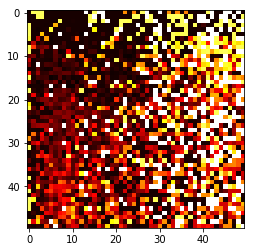

In [74]:
#Running this cell gives a representation of the heat_map. the darker squares represent areas of the lowest error
plt.imshow(heat_map, cmap='hot', interpolation='nearest')
plt.plot()

In [76]:
lowest_error = np.amin(heat_map) #this variable gives the lowest error on the heat_map
best_parameters = parameter_list[np.argmin(heat_map)] #This is a list which gives the parameters used to get the model which 
#gives the lowest_error
best_scale = best_parameters[0]
best_centres = best_parameters[1]

print("the misclassification error when using the best hyperparameters is {}".format(lowest_error))

the misclassification error when using the best hyperparameters is 0.11632270168855534


In [77]:
#first lets create our designmatrix using our best parameters, this could lead to a singular matrix due to the randomness of
#of our centre selection, therefore this cell has a small risk of not running

feature_mapping = construct_rbf_feature_mapping(best_centres,best_scale)
designmtx_RBF = feature_mapping(standardised_data) #our design matrix made using the best parameters

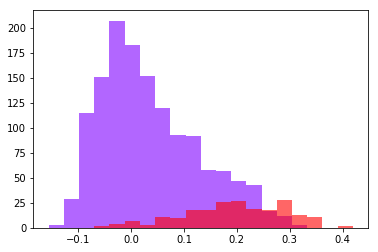

In [78]:
#in this cell we want to plott he histogram this time with our design matrix model to see how linearly seperable our data is
weights = fisher_linear_discriminant_projection(designmtx_RBF, targets) #our weights now calculated using the designmtx_RBF
projected_data = project_data(designmtx_RBF, weights)

plot_class_histograms(projected_data, targets)

plt.show()

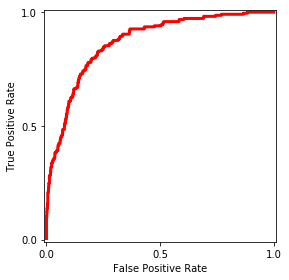

In [79]:
#As can be seen, RBF has not really helped to seperate the data, now we will plot the ROC curve with our new model

new_ordering = np.argsort(projected_data)
sorted_projections = projected_data[new_ordering]
sorted_targets = targets[new_ordering]

num_neg = np.sum(1-targets)
num_pos = np.sum(targets)

#Below is a 2D array with 5 colums. The array is alled roc_data
#Column 1 is numbers in ascending order (ie 1, 2, 3, 4, 5 etc)
#Column 2 is a value of w0
#Column 3 is the false positive rate (FPR) for a given value of w0
#Column 4 is the true positive rate (TPR) for a given value of 
#Column 5 gives the value of TPR - FPR


roc_data = np.empty([N, 5])

for i, w0 in enumerate(sorted_projections):
        roc_data[i,0] = i
        roc_data[i,1] = sorted_projections[i]
        roc_data[i,2] = np.sum(1-sorted_targets[i:])/num_neg
        FPR = roc_data[i,2]
        roc_data[i,3] = np.sum(sorted_targets[i:])/num_pos
        TPR = roc_data[i,3]
        roc_data[i,4] = TPR - FPR
        
plot_roc(roc_data[:,2], roc_data[:,3])

plt.show()

In [80]:
#Now we will try logistic regression to see if that gives
#A better performance, this will be done without basis functions

from fomlads.model.classification import logistic_regression_prediction_probs
from fomlads.model.classification import logistic_regression_predict
from fomlads.model.classification import logistic_regression_fit
from fomlads.evaluate.eval_classification import cross_entropy_error

def logistic_regression_fit_robustINV(
        inputs, targets, weights0=None, threshold=1e-8, lambd = 0.01):
   
    # reshape the matrix for 1d inputs
    if len(inputs.shape) == 1:
        inputs = inputs.reshape((inputs.size,1))
    N, D = inputs.shape
    inputs = np.matrix(inputs)
    targets = np.matrix(targets.reshape((N,1)))
    # initialise the weights
    if weights0 is None:
        weights = np.matrix(
            np.random.multivariate_normal(np.zeros(D), 0.0001*np.identity(D)))
    else:
        weights = np.matrix(weights0)
    weights = weights.reshape((D,1))
    # initially the update magnitude is set as larger than the threshold
    update_magnitude = 2*threshold
    while update_magnitude > threshold:
        # calculate the current prediction vector for weights
        predicts = logistic_regression_prediction_probs(inputs, weights)
        # the diagonal reweighting matrix (easier with predicts as flat array)
        R = np.matrix(np.diag(predicts*(1-predicts)))
        # reshape predicts to be same form as targets
        predicts = np.matrix(predicts).reshape((N,1))
        #print("Before hessian")
        HessianMTX = inputs.T*R*inputs
        HessianDIM = HessianMTX.shape[0]
        
        #lambdI = np.zeros((HessianDIM, HessianDIM), float)
        #np.fill_diagonal(lambdI, lambd)
        lambdI = lambd*np.identity(HessianDIM)
        robustHessian = HessianMTX + lambdI
                
        #print("Before inverse")
        # Calculate the Hessian inverse
        H_inv = np.linalg.inv(robustHessian)
        # update the weights
        new_weights = weights - H_inv*inputs.T*np.matrix(predicts-targets)
        #print("After update")
        # calculate the update_magnitude
        update_magnitude = np.sqrt(np.sum(np.array(new_weights-weights)**2))
        # update the weights
        weights = new_weights
    return weights

def fit_and_plot_roc_logistic_regression(
        inputs, targets, fig_ax=None, colour=None):
    """
    Takes input and target data for classification and fits shared covariance
    model. Then plots the ROC corresponding to the fit model.

    parameters
    ----------
    inputs - a 2d input matrix (array-like), each row is a data-point
    targets - 1d target vector (array-like) -- can be at most 2 classes ids
        0 and 1
    """
    weights = logistic_regression_fit_robustINV(inputs, targets)
    #
    thresholds = np.linspace(0,1,101)
    N = targets.size
    num_neg = np.sum(1-targets)
    num_pos = np.sum(targets)
    # Comment:
    # There is a good deal of code here that is identical with the function:
    # fit_and_plot_roc_generative, how would you refactor things to ensure the
    # majority is only written once? Consider, a new function with signature:
    # evaluate_and_plot_roc(inputs, prediction_function, thresholds)
    # where prediction_function is a function object that is called with two
    # arguments an input and a threshold. You may need to make use
    # of lambda functions to achieve this though.
    false_positive_rates = np.empty(thresholds.size)
    true_positive_rates = np.empty(thresholds.size)
    for i, threshold in enumerate(thresholds):
        prediction_probs = logistic_regression_prediction_probs(inputs, weights)
        predicts = (prediction_probs > threshold).astype(int)
        num_false_positives = np.sum((predicts == 1) & (targets == 0))
        num_true_positives = np.sum((predicts == 1) & (targets == 1))
        false_positive_rates[i] = np.sum(num_false_positives)/num_neg
        true_positive_rates[i] = np.sum(num_true_positives)/num_pos
    fig, ax = plot_roc(
        false_positive_rates, true_positive_rates, fig_ax=fig_ax, colour=colour)
    # and for the class prior we learnt from the model
    predicts = logistic_regression_predict(inputs, weights)
    fpr = np.sum((predicts == 1) & (targets == 0))/num_neg
    tpr = np.sum((predicts == 1) & (targets == 1))/num_pos
    ax.plot([fpr], [tpr], 'rx', markersize=8, markeredgewidth=2)
    return fig, ax


[]

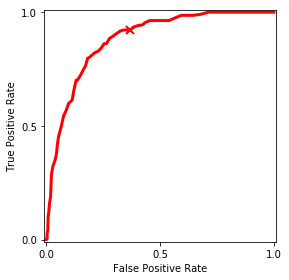

In [81]:
#in this cell we obtain our weights used to create our logistic regression model

fit_and_plot_roc_logistic_regression(standardised_data, targets)

plt.plot()


In [82]:
#In this cell we define the cross validation function for logistic regression

def cross_val_logistic(inputs, targets, folds):
    N = inputs.shape[0] #Number of data points
    num_folds = len(folds) #finds the number of folds
    train_miscl_errors = np.empty(num_folds)
    test_miscl_errors = np.empty(num_folds)
    train_XE_errors = np.empty(num_folds)
    test_XE_errors = np.empty(num_folds)
    for f,fold in enumerate(folds):
        train_part, test_part = fold
        train_inputs, train_targets, test_inputs, test_targets = train_and_test_partition(inputs, targets, train_part, test_part)
        
        weights = logistic_regression_fit_robustINV(train_inputs, train_targets)
        
        train_predicts = logistic_regression_predict(train_inputs, weights)
        test_predicts = logistic_regression_predict(test_inputs, weights)
        
        train_probabilities = logistic_regression_prediction_probs(train_inputs, weights)
        test_probabilities = logistic_regression_prediction_probs(test_inputs, weights)
        
        train_miscl_error = misclassification_error(train_targets, train_predicts)
        test_miscl_error = misclassification_error(test_targets, test_predicts)
        
        
        train_XE_error = cross_entropy_error(train_targets, train_probabilities)
        test_XE_error = cross_entropy_error(test_targets, test_probabilities)
        
        train_miscl_errors[f] = train_miscl_error
        test_miscl_errors[f] = test_miscl_error
        
        train_XE_errors[f] = train_XE_error
        test_XE_errors[f] = test_XE_error
        
    return train_miscl_errors, test_miscl_errors, train_XE_errors, test_XE_errors

In [85]:
train_errors, test_errors, train_XE, test_XE = cross_val_logistic(standardised_data, targets, folds)
print("the misclassification error when using logistic regression is {}".format(np.mean(test_errors)))


the misclassification error when using logistic regression is 0.33020637898686683
